In [30]:
import pandas as pd
import numpy as np
import contractions
import matplotlib.pyplot as plt
import seaborn as sns

# NLP
import spacy
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from urlextract import URLExtract

#Analysis
import gensim
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from gensim.corpora import Dictionary
from gensim.models import LdaModel

In [31]:
filename = "/Users/sameerladha/Documents/School/Masters of Science - Data Science and Analytics/MRP/Datasets/csv/baselinefinal_.csv"
df = pd.read_csv(filename)
texts = df['text']

### Preprocessing

In [32]:
def generate_generic_username(index):
    return f"User{index+1}"

unique_authors = df['author'].unique()
author_mapping = {author: f"User{i+1}" for i, author in enumerate(unique_authors)}
df['author'] = df['author'].map(author_mapping)

In [33]:
nlp = spacy.load("en_core_web_sm")
stop_words = set(stopwords.words('english'))
extractor = URLExtract()

lemmatizer = WordNetLemmatizer()

def is_url(token):
    return token.like_url

# Function to preprocess text
def process_text(text):
    if pd.isnull(text):
        return ["text_missing"]
    
    text = text.lower()
    text = contractions.fix(text)
    
    # Process text with spaCy
    doc = nlp(text)
    
    # Tokenization, stop word removal, URL removal, and short token filtering
    tokens = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop and not is_url(token)]
    tokens = [tokens for tokens in tokens if len(tokens) > 4]
    
    return tokens

In [34]:
# Preprocess the texts
processed_texts = [process_text(text) for text in texts]
# Remove texts that are missing
processed_texts = [text for text in processed_texts if text != ["text_missing"]]

### Data Preparation

In [35]:
# Create bigrams and trigrams
bigram = Phrases(processed_texts, min_count=5, threshold=100)
trigram = Phrases(bigram[processed_texts], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

# Function to apply bigrams and trigrams
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

# Apply bigrams and trigrams
texts_bigrams = make_bigrams(processed_texts)
texts_trigrams = make_trigrams(processed_texts)

In [36]:
# Create Dictionary
id2word = Dictionary(texts_trigrams)

# Filter extremes to remove very rare and very common words
id2word.filter_extremes(no_below=20, no_above=0.4)

# Create Corpus
texts_corpus = [id2word.doc2bow(text) for text in texts_trigrams]

### Building the Model

In [37]:
# Build LDA model
lda_model = LdaModel(corpus=texts_corpus,
                     id2word=id2word,
                     num_topics=5, 
                     random_state=100,
                     update_every=1,
                     chunksize=500,
                     passes=25,
                     iterations=100,
                     alpha='auto',
                     per_word_topics=True)

In [38]:
# Function to calculate coherence score
def compute_coherence_score(lda_model, texts, dictionary, coherence='c_v'):
    coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence=coherence)
    coherence_score = coherence_model.get_coherence()
    return coherence_score

# Function to calculate perplexity
def compute_perplexity(lda_model, corpus):
    perplexity = lda_model.log_perplexity(corpus)
    return perplexity

def display_formatted_topics(lda_model, num_words):
    topics = lda_model.print_topics(num_words=num_words)
    for topic in topics:
        topic_id, topic_words = topic
        print(f"Topic {topic_id}:")
        words = topic_words.split(" + ")
        for word in words:
            weight, term = word.split("*")
            print(f"  {term.strip()} ({float(weight):.3f})")
        print("\n")

coherence_score = compute_coherence_score(lda_model, texts_trigrams, id2word)
print(f"Coherence Score: {coherence_score:.3f}")

perplexity = compute_perplexity(lda_model, texts_corpus)
print(f"Perplexity: {perplexity:.3f}")

print("LDA Topics:")
display_formatted_topics(lda_model, num_words=15)

Coherence Score: 0.615
Perplexity: -6.866
LDA Topics:
Topic 0:
  "district" (0.028)
  "charge" (0.024)
  "today" (0.023)
  "demand" (0.023)
  "hamas" (0.022)
  "independent" (0.020)
  "bernie" (0.019)
  "admit" (0.017)
  "school" (0.015)
  "count" (0.015)
  "swing" (0.014)
  "realize" (0.014)
  "general" (0.014)
  "ballot" (0.013)
  "moderate" (0.013)


Topic 1:
  "state" (0.055)
  "migrant" (0.035)
  "money" (0.034)
  "government" (0.033)
  "start" (0.027)
  "worker" (0.021)
  "federal" (0.016)
  "foreign" (0.016)
  "delete" (0.015)
  "current" (0.015)
  "funding" (0.014)
  "benefit" (0.013)
  "member" (0.011)
  "large" (0.011)
  "provide" (0.011)


Topic 2:
  "trump" (0.163)
  "election" (0.060)
  "president" (0.051)
  "court" (0.023)
  "office" (0.022)
  "campaign" (0.021)
  "appeal" (0.016)
  "order" (0.014)
  "elect" (0.014)
  "article" (0.013)
  "politic" (0.013)
  "criminal" (0.013)
  "decision" (0.012)
  "impeach" (0.011)
  "supreme_court" (0.011)


Topic 3:
  "border" (0.050)


### Tuning the Model to determine the optimal number of topics

In [39]:
# Function to calculate coherence values for a range of topic numbers
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1, coherence='c_v'):
    coherence_values = []
    model_list = []
    total_models = (limit - start) // step + 1
    current_model_count = 0
    
    for num_topics in range(start, limit, step):
        lda_model = gensim.models.ldamodel.LdaModel(
            corpus=corpus, 
            id2word=dictionary, 
            num_topics=num_topics,
            random_state=100, 
            update_every=1, 
            chunksize=500, 
            iterations=100, 
            passes=25, 
            alpha='auto', 
            per_word_topics=False
        )
        model_list.append(lda_model)
        
        coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence=coherence)
        coherence_values.append(coherence_model.get_coherence())
        
        current_model_count += 1
        print(f"Built {current_model_count} of {total_models} models")
    
    return model_list, coherence_values

def visualize_coherence_values(limit, start, step, coherence_values):
    x = range(start, limit, step)
    plt.figure(figsize=(10, 8))
    plt.plot(x, coherence_values, marker='o', linestyle='-', color='b')
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence Score")
    plt.title("Coherence Scores for Different Number of Topics")

    # Annotate each point with its coherence score
    for i, (num_topics, coherence) in enumerate(zip(x, coherence_values)):
        plt.annotate(f"{coherence:.3f}", (num_topics, coherence), textcoords="offset points", xytext=(0, 10), ha='center')
    plt.show()


Built 1 of 6 models
Built 2 of 6 models
Built 3 of 6 models
Built 4 of 6 models
Built 5 of 6 models


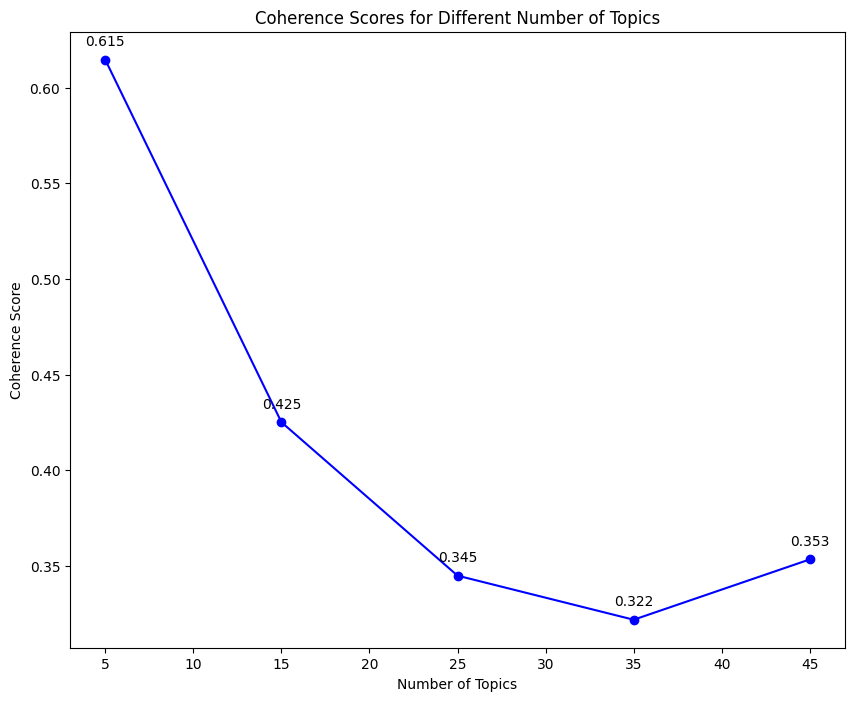

In [40]:
limit=55; start=5; step=10
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=texts_corpus, texts=texts_trigrams, start=start, limit=limit, step=step)
visualize_coherence_values(limit, start, step, coherence_values)

Built 1 of 11 models
Built 2 of 11 models
Built 3 of 11 models
Built 4 of 11 models
Built 5 of 11 models
Built 6 of 11 models
Built 7 of 11 models
Built 8 of 11 models
Built 9 of 11 models
Built 10 of 11 models


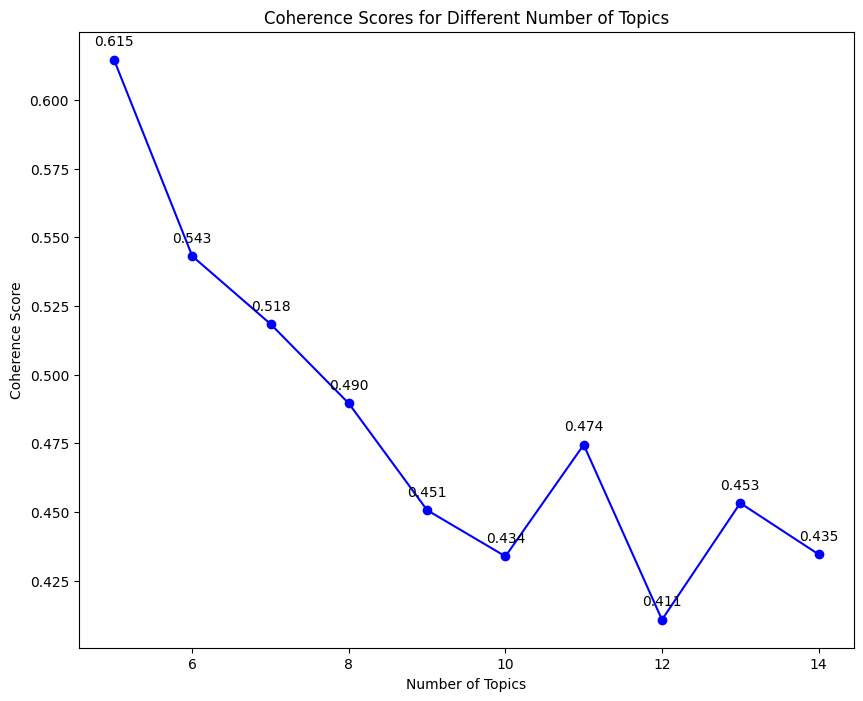

In [42]:
limit=10; start=5; step=1
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=texts_corpus, texts=texts_trigrams, start=start, limit=limit, step=step)
visualize_coherence_values(limit, start, step, coherence_values)

### Final Model

In [43]:
# Build LDA model with optimal number of topics
lda_model = LdaModel(corpus=texts_corpus,
                     id2word=id2word,
                     num_topics=5, 
                     random_state=100,
                     update_every=1,
                     chunksize=500,
                     passes=5,
                     iterations=100,
                     alpha='auto',
                     per_word_topics=True)

In [44]:
coherence_score = compute_coherence_score(lda_model, texts_trigrams, id2word)
print(f"Coherence Score: {coherence_score:.3f}")

perplexity = compute_perplexity(lda_model, texts_corpus)
print(f"Perplexity: {perplexity:.3f}")

print("LDA Topics:")
display_formatted_topics(lda_model, num_words=15)

Coherence Score: 0.567
Perplexity: -6.884
LDA Topics:
Topic 0:
  "district" (0.028)
  "hamas" (0.023)
  "demand" (0.023)
  "today" (0.022)
  "charge" (0.022)
  "independent" (0.020)
  "bernie" (0.020)
  "supreme_court" (0.019)
  "admit" (0.017)
  "school" (0.015)
  "swing" (0.015)
  "count" (0.014)
  "general" (0.014)
  "realize" (0.014)
  "moderate" (0.013)


Topic 1:
  "state" (0.054)
  "migrant" (0.035)
  "money" (0.033)
  "government" (0.033)
  "start" (0.027)
  "worker" (0.022)
  "foreign" (0.016)
  "current" (0.015)
  "delete" (0.015)
  "federal" (0.015)
  "funding" (0.014)
  "benefit" (0.013)
  "member" (0.011)
  "large" (0.011)
  "provide" (0.011)


Topic 2:
  "trump" (0.172)
  "president" (0.052)
  "election" (0.041)
  "court" (0.023)
  "office" (0.022)
  "campaign" (0.020)
  "elect" (0.015)
  "appeal" (0.015)
  "article" (0.014)
  "politic" (0.014)
  "impeach" (0.012)
  "remember" (0.011)
  "trial" (0.011)
  "order" (0.010)
  "major" (0.010)


Topic 3:
  "border" (0.050)
  "b